In [ ]:
!pip install gpboost
!pip install shap
!pip install pdpbox
!pip install tensorflow_decision_forests

In [ ]:
# load packages
import pandas as pd
import numpy as np
import gpboost as gpb
import matplotlib.pyplot as plt
import geopandas as gpd
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_percentage_error as mape, mean_squared_error as mse
from pyarrow import feather as pq
import geopandas as gpd
import folium
from folium import Marker
from shapely import geometry
from tqdm import tqdm
pd.set_option('display.max_columns', None)
from ipywidgets import interact
import scipy
from tqdm import tqdm
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import os
import shap
import random

In [ ]:
# mount drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
# load data for monthly performance
data = pd.read_csv("/content/gdrive/MyDrive/Aurora_Thesis/data_converted.csv")
data.time = pd.to_datetime(data.time)
# keep only where I have OA measurements
data = data.loc[data.OAtot_PMF.isnull()== False,:]
# need to manually add 2 station Id
data.loc[data.station== "Bologna (BO)", "station_id"] = "ID1999"
data.loc[data.station== "San Pietro Capofiume (SPC)", "station_id"] = "ID1998"
# switch London data
data["OAtot_2"] = data.HOA_PMF + data.BBOA_PMF + data.OOAtot_PMF
data.loc[data.station == "London","OAtot_PMF"] = data.loc[data.station == "London","OAtot_2"]
# Remove Zurich 2017
data = data.loc[(data.station != "Zurich") | (data.year != 2017),:]
# CLEAN DATA
# remove OA with less than 0.1
data= data.loc[data.OAtot_PMF >= 0.1, :]
# remove if CAMX is not present (i.e. equal to zero)
data = data.loc[data.OAtot_CAMX != 0,:]
# and stations with less than 30 obs.
select = (data.groupby("station_id")["OAtot_PMF"].size() > 30).reset_index()
data = data.set_index("station_id")
data = data.join(select.set_index("station_id"), rsuffix = "keep")
data = data.loc[ data.OAtot_PMFkeep == True, :]
data = data.reset_index()

In [ ]:
# remove Outliers
robust_mode = True
plot = 0
# change here for desired number of plots
max_plots = 1

# count from which dataset we remove the outlier
online_count = 0
ebas_count = 0
riurban_count = 0

data["n_outlier"] = np.zeros(len(data))

if robust_mode:
    start_0 = (data.OAtot_PMF==0).sum()
    # remove outliers (or impute?), i.e. if measured OA > threshold
    # compute upper and lower limit for outlier detection
    upper = data.groupby(["year","month","station_id"])["OAtot_PMF"].apply(lambda x: np.quantile(x, 0.75) + 3*scipy.stats.iqr(x)).reset_index()
    lower = data.groupby(["year","month","station_id"])["OAtot_PMF"].apply(lambda x: np.quantile(x, 0.25) - 3*scipy.stats.iqr(x)).reset_index()
    #upper = data.groupby(["year","month","station_id"])["OAtot_PMF"].apply(lambda x: np.median(x) + 3*scipy.stats.median_abs_deviation(x, scale=1)).reset_index()
    #lower = data.groupby(["year","month","station_id"])["OAtot_PMF"].apply(lambda x: np.median(x) - 3*scipy.stats.median_abs_deviation(x, scale=1)).reset_index()
    for i in tqdm(range(len(data))):
        station= data.iloc[i,:].station_id
        year = data.iloc[i,:].year
        month = data.iloc[i,:].month
        # get upper and lower value of threshold
        up = upper.loc[(upper.station_id == station) & (upper.year == year) & (upper.month == month), "OAtot_PMF"]
        lo = lower.loc[(lower.station_id == station) & (lower.year == year) & (lower.month == month), "OAtot_PMF"]

        # if threshold is negative replace it with 0
        if lo.iloc[0] < 0:
            lo.iloc[0] = 0
        # check here if outside interval defined by [lower, upper]
        if (data.iloc[i,:].OAtot_PMF > up.iloc[0]) | (data.iloc[i,:].OAtot_PMF < lo.iloc[0]):

            # compute relative error
            oa = data.iloc[i,:].OAtot_PMF
            camx = data.iloc[i,:].OAtot_CAMX
            r_e = (oa - camx)/(oa) # or divided by CAMX
            # remove only if also big disagreement with CAMX
            if r_e > 0.5:

                if plot < max_plots:
                    fig, ax = plt.subplots(2,1, figsize = (16,9))
                    sns.set_style("whitegrid")
                    ax[0].plot(data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"time"],
                    data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"OAtot_PMF"], label = "OA")
                    ax[0].plot(data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"time"],
                    data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"OAtot_CAMX"], label = "CAMX")
                    ax[0].set_ylabel("OA", fontsize = 24)
                    #ax[0].set_xlabel("time", fontsize = 24)
                    #ax[0].set_xticklabels(ax[0].get_xticks(), fontsize = 20)
                    ax[0].tick_params(axis='x', which='major', labelsize=14, rotation = 30)
                    ax[0].tick_params(axis='y', which='major', labelsize=20)


                    oa = data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"OAtot_PMF"]
                    camx = data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"OAtot_CAMX"]
                    r_e = (oa - camx)/(oa)
                    ax[1].plot(data.loc[(data.station_id == station)&(data.month == month) & (data.year == year),"time"],
                    r_e, color = "green", label = "relative_error")
                    ax[1].axline( xy1 = (0,0.5),slope = 0, color = "red")
                    ax[1].set_ylabel("Relative error", fontsize = 24)


                    # get axis
                    # Save the original xlim and ylim values
                    xlim = ax[0].get_xlim()

                    ax[0].axline( xy1 = (0,up.iloc[0]),slope = 0, color = "red")
                    ax[0].axline( xy1 = (0,lo.iloc[0]), slope = 0,  color = "red")

                    stat_name = data.loc[data.station_id == station, "station"].iloc[0]
                    ax[0].set_title(stat_name, fontsize = 24)
                    # set axis
                    ax[0].set_xlim(xlim)
                    ax[1].set_xlim(xlim)
                    ax[0].legend(fontsize = 24)
                    ax[1].legend(fontsize = 24)
                    ax[1].tick_params(axis='x', which='major', labelsize=14, rotation = 30)
                    ax[1].tick_params(axis='y', which='major', labelsize=20)
                # Save the plot
                #file_path = os.path.join(folder_path, 'my_plot_' + str(station) + ".png")
                #plt.savefig(file_path)
                plt.tight_layout()
                plt.show()
                plot += 1

                # from which station
                data.n_outlier.iloc[i] = data.n_outlier.iloc[i] + 1

                # here could also do some imputation instead
                data.OAtot_PMF.iloc[i] = 0

                # count from which dataset
                dataset = data.loc[data.station_id == station, "dataset"].iloc[0]
                if dataset == "online":
                    online_count += 1
                elif dataset == "ebas":
                    ebas_count += 1
                else:
                    riurban_count += 1

end_0 = (data.OAtot_PMF == 0).sum()
print("outlier removed:", end_0 - start_0 )
print(" Online outliers:", online_count)
print(" Ebas outliers:", ebas_count)
print(" Riurban outliers:", riurban_count)
# keep data points different from 0
data = data.loc[data.OAtot_PMF != 0, :]# target metric of choice

In [ ]:
def my_mape(Y_true, Y_pred):
    loss = (np.abs( (Y_true - Y_pred)/(Y_true + 1))).mean()
    return loss

In [ ]:
# targets: monthly or daily
monthly = True
if monthly:
    # monthly performance
    monthly_score = data.groupby(["year","month","station_id"])[["OAtot_PMF","OAtot_CAMX"]].apply(lambda x : my_mape(x.iloc[:, 0], x.iloc[:,1]))
    monthly_score = monthly_score.reset_index().rename(columns = {0:"score"})
else:
    # daily performance (check)
    data["day_performance"] = np.abs((data["OAtot_PMF"] - data["OAtot_CAMX"]) / (data["OAtot_PMF"] + 1))

In [ ]:
# feature engineering (new features: elevation, wind x, wind y, add station angle, population, imd, ports, inorganics, OA proportions)
# road_coverage
data["rc_1_1000-rc_1_100"] = data["road_class_1_1000"] - data["road_class_1_100"]
data["rc_2_1000-rc_2_100"] = data["road_class_2_1000"] - data["road_class_2_100"]
data["rc_3_1000-rc_3_100"] = data["road_class_3_1000"] - data["road_class_3_100"]
# CAMX proportions of components of OA
data["p_HOA"] = data["HOA_CAMX"] / data["OAtot_CAMX"]
data["p_BBOA"] = data["BBOA_CAMX"] / data["OAtot_CAMX"]
data["p_OOAtot"] = data["OOAtot_CAMX"] / data["OAtot_CAMX"]

# need to decorralate some land-use variables
data["diff_agriculture"] = data["agriculture1000"] - data["agriculture500"]
data["diff_airports"] = data["airports1000"] - data["airports500"]
data["diff_barren"] = data["barren1000"] - data["barren500"]
data["diff_industrial"] = data["industrial1000"] - data["industrial500"]
data["diff_industrial_transport"]= data["industrial_transport1000"] - data["industrial_transport500"]
data["diff_natural_green"] =  data["natural_green1000"] - data["natural_green500"]
data["diff_ports"] = data["ports1000"] - data["ports500"]
data["diff_roads_rails"] = data["roads_rails1000"] - data["roads_rails500"]
data["diff_snow_ice"] = data["snow_ice1000"] - data["snow_ice500"]
data["diff_transport"] = data["transport1000"] - data["transport500"]
data["diff_urban_fabric"] = data["urban_fabric1000"] - data["urban_fabric500"]
data["diff_urban_green"] = data["urban_green1000"] - data["urban_green500"]
data["diff_water"] = data["water1000"] - data["water500"]
data["diff_wetlands"] = data["wetlands1000"] - data["wetlands500"]
# also for Population and IMD
data["diff_population"] = data["population_1000"] - data["population_500"]
data["diff_imd"] = data["imd1000"] - data["imd500"]

# add day of week
data["day_of_week"] = data.time.dt.day_of_week

if monthly:
    # aggregate and take mean and std. dev.

    # monthly features, like temp, pressure, wind, etc... include also std.dev.
    mean_weather = data.groupby(["year","month","station_id"])[["temp_CAMX","rh_CAMX","press_CAMX","ws_CAMX", "wd_CAMX","pblh_CAMX", "wind_x_CAMX", "wind_y_CAMX" ]].mean().reset_index()
    std_weather = data.groupby(["year","month","station_id"])[["temp_CAMX","rh_CAMX","press_CAMX","ws_CAMX","wd_CAMX","pblh_CAMX",  "wind_x_CAMX", "wind_y_CAMX"]].std().reset_index()

    # average OA levels and proportions of components and inorganics
    # WHERE IS  "EC_CAMX" ?
    oa_inorganics = data.groupby(["year","month","station_id"])["OAtot_PMF","SO4_CAMX", "NH4_CAMX", "NO3_CAMX", "O3_CAMX", "NOx_CAMX", "p_HOA","p_BBOA", "p_OOAtot"].mean().reset_index()

    # geospatial features, like distance to center, to grid edge, area size, Lat and Lon
    geo_features = data.groupby(["year","month","station_id"])[["distance_mt","distance_border","area_grid"]].mean().reset_index()

    # land-use features: industrial, water, etc.. (Abhishek's data)
    land_features = data.groupby(["year","month","station_id"])[["diff_agriculture", "diff_airports", "diff_barren", "diff_industrial", "diff_industrial_transport",
    "diff_natural_green", "diff_ports", "diff_roads_rails", "diff_snow_ice", "diff_transport", "diff_urban_fabric", "diff_urban_green", "diff_water", "diff_wetlands",
    "agriculture500","airports500", "barren500", "industrial500", "industrial_transport500", "natural_green500", "ports500", "roads_rails500", "snow_ice500",
    "transport500", "urban_fabric500","urban_green500", "water500", "wetlands500","diff_imd","imd500", "diff_population", "population_500","elevation","Lat","Lon"]].mean().reset_index()

    # road coverage
    road_features = data.groupby(["year","month","station_id"])[["road_class_1_100","rc_1_1000-rc_1_100", "rc_2_1000-rc_2_100","road_class_2_100",
                                     "rc_3_1000-rc_3_100","road_class_3_100"]].mean().reset_index()
    road_features = road_features.fillna(0)

    # add dataset
    dataset_feature= data.groupby(["year","month","station_id"])["dataset"].unique().reset_index()

    # some cleaning
    mean_weather= mean_weather.drop(["year","month", "station_id"],axis = 1)
    std_weather= std_weather.drop(["year","month","station_id"],axis = 1)
    geo_features= geo_features.drop(["year","month","station_id"],axis = 1)
    land_features= land_features.drop(["year","month","station_id"],axis = 1)
    road_features=  road_features.drop(["year","month","station_id"],axis = 1)
    #dataset_feature = dataset_feature.drop(["year","month","station_id"],axis = 1)
    oa_inorganics = oa_inorganics.drop(["year","month","station_id"],axis = 1)

    # replace std.dev. with CV
    for col in std_weather.columns[3:]:
        # add coefficent of Variation
        data[col + "cv"] = std_weather[col] /mean_weather[col]

   # some renaming
    std_weather = std_weather.rename(columns={"temp_CAMX":"temp_std", "rh_CAMX":"rh_std", "press_CAMX":"press_std",
                                            "ws_CAMX":"ws_std","wd_CAMX":"wd_std","pblh_CAMX":"pbhl_std", "wind_x_CAMX":"wd_x_std", "wind_y_CAMX":"wd_y_std"})

    # create full matrix
    data_fit = pd.concat( (monthly_score, mean_weather, std_weather, geo_features,
                            land_features, road_features,
                            oa_inorganics),axis = 1) #dataset_feature

    # fill NA
    data_fit = data_fit.fillna(0)

    # remove std.dev.
    for col in std_weather.columns[3:]:
        # drop standard deviation
        data_fit = data_fit.drop(col, axis = 1)

# here if DAILY!
else:
    # daily values --> just get the right features
    data_fit = data.loc[:, ["station_id","day_performance", "year", "month","day_of_week", "temp_CAMX","rh_CAMX","press_CAMX","ws_CAMX", "wd_CAMX","pblh_CAMX", "wind_x_CAMX", "wind_y_CAMX" ,
    "OAtot_PMF", "distance_mt","distance_border","area_grid", "diff_agriculture", "diff_airports", "diff_barren", "diff_industrial", "diff_industrial_transport",
    "diff_natural_green", "diff_ports", "diff_roads_rails", "diff_snow_ice", "diff_transport", "diff_urban_fabric", "diff_urban_green", "diff_water", "diff_wetlands",
    "agriculture500","airports500", "barren500", "industrial500", "industrial_transport500", "natural_green500", "ports500", "roads_rails500", "snow_ice500",
    "transport500", "urban_fabric500","urban_green500", "water500", "wetlands500","diff_imd","imd500", "diff_population", "population_500","elevation","Lat","Lon",
    "road_class_1_100","rc_1_1000-rc_1_100", "rc_2_1000-rc_2_100","road_class_2_100","rc_3_1000-rc_3_100","road_class_3_100",
    "SO4_CAMX", "NH4_CAMX", "NO3_CAMX", "O3_CAMX", "NOx_CAMX","p_HOA","p_BBOA","p_OOAtot"]]
    # make dataset variable a dummy
    # fill NA
    data_fit = data_fit.fillna(0)

In [ ]:
# check correlation
#plt.figure(figsize = (16,9))
#sns.heatmap(data_fit.corr())

# or
plt.figure(figsize = (30,20))
mask = np.triu(np.ones_like(data_fit.corr()))
sns.heatmap(data_fit.corr(), cmap="YlGnBu", mask = mask)#

In [ ]:
# remove them if Monthly:
data_fit = data_fit.drop(["diff_snow_ice", "diff_airports",
                          "airports500", "snow_ice500"], axis = 1)

In [ ]:
### cluster highly correlated features
from collections import defaultdict
import scipy
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 9))
# IMPORTANT: drop score (Y) from clustering step
corr = spearmanr(data_fit.drop("score",axis = 1)).correlation

# Ensure the correlation matrix is symmetric
corr = (corr + corr.T) / 2
np.fill_diagonal(corr, 1)

# We convert the correlation matrix to a distance matrix before performing
# hierarchical clustering using Ward's linkage.
distance_matrix = 1 - np.abs(corr)
dist_linkage = hierarchy.ward(squareform(distance_matrix))
dendro = hierarchy.dendrogram(
    dist_linkage, labels=data_fit.drop("score", axis = 1).columns, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro["ivl"]))

ax2.imshow(corr[dendro["leaves"], :][:, dendro["leaves"]])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro["ivl"], rotation="vertical")
ax2.set_yticklabels(dendro["ivl"])
fig.tight_layout()
plt.show()

In [ ]:
# visually selected threshold
t = 0.75
# take first feature in each cluster
cluster_ids = hierarchy.fcluster(dist_linkage, t, criterion="distance")
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
# make sure to droo the response "score"
data_fit = pd.concat( (data_fit.score, data_fit.drop("score",axis =1).iloc[:, selected_features]),axis = 1)

In [ ]:
# make dataset variable a dummy
if monthly:
    data_fit = pd.concat( (data_fit, pd.get_dummies(dataset_feature.dataset.map(lambda x: x[0]) ) ), axis = 1 )
else:
    data_fit = pd.concat( (data_fit, pd.get_dummies(data.dataset)), axis = 1 )

In [ ]:
# check again
sns.set_style("whitegrid")
plt.figure(figsize = (20,10))
mask = np.triu(np.ones_like(data_fit.drop("score",axis = 1).corr()))
sns.heatmap(data_fit.drop("score",axis = 1).corr(), cmap="YlGnBu", mask = mask)#

In [ ]:
# remove when score == NaN (just)
if monthly:
    data_fit = data_fit.loc[ data_fit.score.isnull() == False, :]
else:
    data_fit = data_fit.loc[ data_fit.day_performance.isnull() == False, :]

In [ ]:
#add station name and save csv
stat_name = pd.DataFrame(data.groupby("station_id")["station"].unique())
coords = pd.DataFrame(data.groupby("station_id")["Lat","Lon"].mean())
data_fit = data_fit.set_index("station_id").join(stat_name)
data_fit = data_fit.join(coords)

In [ ]:
data = data_fit.copy()
# station name
station = data.pop("station")
# station id
groups = data.reset_index().station_id
Y = data.pop("score").reset_index(drop=True)
# leave lat and lon there!!!
Lat = data.loc[:,"Lat"]
Lon = data.loc[:, "Lon"]
# fill NA with zeros
data = data.fillna(0)
#data = data.reset_index(drop=True)

In [ ]:
# nested CV to tune and compute prediction performance
# groupKfold
n_splits = 10  #10 for monthly # 5 for daily
B = 100 # for permutation test
kfold = GroupKFold(n_splits= n_splits)
# store results
res_forest = dict()
res_boost = dict()
res_gp = dict()
observed = dict()

# PERMUTATION TEST
T_rf = np.zeros(n_splits)
T_boost = np.zeros(n_splits)
T_gp = np.zeros(n_splits)
res_forest_perm =  pd.DataFrame( np.zeros((n_splits, B)))
res_boost_perm = pd.DataFrame( np.zeros((n_splits, B)))
res_gp_perm = pd.DataFrame( np.zeros((n_splits, B)))

for idx, (train_idx, test_idx) in tqdm(enumerate(kfold.split(data,Y,groups))):
   # get data
    X_train = data.iloc[train_idx,:]
    X_test = data.iloc[test_idx,:]
    Y_train = Y.iloc[train_idx]
    Y_test = Y.iloc[test_idx]

    # train regressors
    rf = RandomForestRegressor(random_state=99, n_jobs=-1, n_estimators=500) # try again with this number of estimators
    boost = GradientBoostingRegressor(random_state=99, n_estimators = 200) # 500 for monthly
    # GridSearch
    innner_kfold = GroupKFold(n_splits=5) # 5 for monthly
    inner_groups = groups.iloc[train_idx]
    param_rf = {"max_features":["sqrt","log2"]}
    param_boost = {"max_depth":[3,5,10],  "learning_rate":[0.001, 0.01,0.1]} # also 0.001 for monthly
    clf = GridSearchCV(rf, param_grid= param_rf, cv = innner_kfold.split(X_train, Y_train, inner_groups))
    clf.fit(X_train, Y_train)
    clf2 = GridSearchCV(boost, param_grid= param_boost, cv = innner_kfold.split(X_train, Y_train, inner_groups))
    clf2.fit(X_train, Y_train)

    # GP-BOOST
    data_train = gpb.Dataset(data=X_train, label=Y_train)
    likelihood = "gaussian"
    gp_model = gpb.GPModel(group_data=inner_groups, likelihood=likelihood)
    num_boost_round = 1000
    param_grid = {'learning_rate': [1,0.1,0.01, 0.001],
                      'min_data_in_leaf': [10,100,1000],
                      'max_depth': [1,2,3,5,10],
                      'lambda_l2': [0,1,10]}
    other_params = {'num_leaves': 2**10, 'verbose': 0}
    # split in train and validation data
    split_2 = GroupKFold(n_splits = 2)
    for train_idx, test_idx in split_2.split(X_train,Y_train, inner_groups):
      train_idx = train_idx
      test_idx = test_idx
    folds = [(train_idx, test_idx)]
    opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid, params=other_params,
                                                    num_try_random=None, seed=1000, #n_folds = 4
                                                    train_set=data_train, gp_model=gp_model, folds = folds, # folds = innner_kfold.split(X_train, Y_train, inner_groups), #stratified = True,
                                                    use_gp_model_for_validation=True, verbose_eval=1,
                                                    num_boost_round=num_boost_round, early_stopping_rounds=10, metric = "mse")
    # Train
    cvbst = gpb.cv(params=opt_params["best_params"], train_set=data_train,
               gp_model=gp_model, use_gp_model_for_validation=True, folds = folds, # innner_kfold.split(X_train, Y_train, inner_groups),
               num_boost_round=1000, early_stopping_rounds=50, #original 10 # nfolds = 4
                verbose_eval=True, show_stdv=False, seed=1)
    metric_name = list(cvbst.keys())[0]
    print("Best number of iterations: " + str(np.argmin(cvbst[metric_name])))
    best_num_iter = np.argmin(cvbst[metric_name])
   #
    if best_num_iter == 0:
      best_num_iter = 1
    bst = gpb.train(params= opt_params['best_params'], train_set=data_train,  gp_model=gp_model,
                    num_boost_round=best_num_iter)
    #gp_model.summary() # Estimated random effects model
    gp_pred = bst.predict(data=X_test, group_data_pred=groups.iloc[test_idx], predict_var=True, pred_latent=True)

    # store result per stations
    stat_id = groups.iloc[test_idx].unique()
    for station in stat_id:
        x_test = data.loc[pd.Series(groups == station),:]
        y_test = Y.loc[pd.Series(groups == station)]
        res_forest[station] = clf.predict(x_test)
        res_boost[station] = clf2.predict(x_test)
        res_gp[station] = bst.predict(x_test, group_data_pred=groups.iloc[test_idx], predict_var=True, pred_latent=True)["fixed_effect"]
        observed[station] = y_test

    # PERMUTATION TEST
    # my test statistics
    T_rf[idx] = mse(Y_test, clf.predict(X_test))
    T_boost[idx] = mse(Y_test, clf2.predict(X_test))
    T_gp[idx] = mse(Y_test, gp_pred['fixed_effect'])


    # for B = 100, permute Y, fit model and store mse in vector
    mse_rf = np.zeros(B)
    mse_boost = np.zeros(B)
    mse_gp = np.zeros(B)
    random.seed(41)
    for i in range(B):
        # permute Y --> sample indeces uniformly without replacement
        n = len(Y_train)
        indeces_per =  random.sample(range(n), n)  # some function to sample indeces without replacement
        Y_perm = Y_train.iloc[indeces_per]
        # fit RF with optimal hypers
        clf.best_estimator_.fit(X_train, Y_perm)
        # fit boost with optimal hypers
        clf2.best_estimator_.fit(X_train, Y_perm)

        # For random effects model --> permute within cluster
        Y_perm = Y_train.copy(deep = True)
        for l in inner_groups.unique():
          # permute Y with-in group l
          Y_l = Y_train.loc[inner_groups == l]
          Y_perm.loc[inner_groups == l] = np.array(Y_l.sample(frac = 1, random_state = 00))

        # fit best gpmodel
        data_perm = gpb.Dataset(data=X_train, label= Y_perm)
        perm_trained = gpb.train(params=opt_params['best_params'], train_set=data_perm,  gp_model=gp_model,
                    num_boost_round=best_num_iter)
        # store result
        mse_rf[i] = mse(Y_test,clf.predict(X_test) )
        mse_boost[i] = mse(Y_test,clf2.predict(X_test) )
        mse_gp[i] =  mse(Y_test, perm_trained.predict(X_test, group_data_pred=groups.iloc[test_idx], predict_var=True, pred_latent=True)["fixed_effect"])

    # store result
    res_forest_perm.iloc[idx,:] = mse_rf
    res_boost_perm.iloc[idx,:] = mse_boost
    res_gp_perm.iloc[idx,:] = mse_gp


In [ ]:
# save results of perm
np.save('res_forest.npy', res_forest_perm)
np.save('res_boost.npy', res_boost_perm)
np.save('res_gp.npy', res_gp_perm)
# save res of performance
np.save('T_rf.npy', T_rf)
np.save('T_boost.npy', T_boost)
np.save('T_gp.npy', T_gp)

In [ ]:
# get results
mean_forest_perm = res_forest_perm.mean(axis = 0)
mean_boost_perm = res_boost_perm.mean(axis = 0)
mean_gp_perm = res_gp_perm.mean(axis = 0)
plt.figsize(16,9)
plt.hist(mean_forest_perm)
plt.axvline(x = T_rf.mean())
plt.title("Permutation Test", fontsize = 24)
plt.ylabel("Frequ")

In [ ]:
# distribution for boosting
plt.hist(mean_boost_perm)
plt.axvline(x = T_boost.mean())

In [ ]:
# distribution for GP-Boost
plt.hist(mean_gp_perm)
plt.axvline(x = T_gp.mean())

In [ ]:
# prediction performance
print("rf", T_rf.mean())
print("boost", T_boost.mean())
print("gp", T_gp.mean())

rf 0.08308823168029197
boost 0.10230933510992819
gp 0.09424329232710803


In [ ]:
# empirical p-values
1/101

0.009900990099009901

# Obtain Feature Importance Metrics

In [ ]:
# Define random effects model
data_train = gpb.Dataset(data=data, label=Y)
split = GroupKFold(n_splits = 8)
for train_idx, test_idx in split.split(data, Y, groups):
  train_idx = train_idx
  test_idx = test_idx
folds = [(train_idx, test_idx)]
likelihood = "gaussian"
gp_model = gpb.GPModel(group_data=groups, likelihood=likelihood)
num_boost_round = 1000
param_grid = {'learning_rate': [1,0.1,0.01, 0.001, 0.0001],
                  'min_data_in_leaf': [10,100,1000],
                  'max_depth': [1,2,3,5,10],
                  'lambda_l2': [0,1,10]}
other_params = {'num_leaves': 2**10, 'verbose': 0}
opt_params = gpb.grid_search_tune_parameters(param_grid=param_grid, params=other_params,
                                                 num_try_random=None, seed=1000, nfold=4,
                                                 train_set=data_train, # folds = folds,
                                                 gp_model=gp_model,
                                                 use_gp_model_for_validation=True, verbose_eval=1,
                                                 num_boost_round=num_boost_round, early_stopping_rounds=10, metric = "mse")
print(opt_params)
gp_model = gpb.GPModel(group_data=groups, likelihood=likelihood)
cvbst = gpb.cv(params=opt_params["best_params"], train_set=data_train,
               gp_model=gp_model, use_gp_model_for_validation=True,nfold=4,#folds = folds
               num_boost_round=1000, early_stopping_rounds=50, #original 10
               verbose_eval=True, show_stdv=False, seed=1)
metric_name = list(cvbst.keys())[0]
print("Best number of iterations: " + str(np.argmin(cvbst[metric_name])))
best_num_iter = np.argmin(cvbst[metric_name])
# Train
bst = gpb.train(params=opt_params["best_params"], train_set=data_train,  gp_model=gp_model,
                num_boost_round=best_num_iter)
gp_model.summary() # Estimated random effects model

In [ ]:
print("std.dev of noise term", np.sqrt(0.0502))
print("std.dev of random effect", np.sqrt(0.0174))
print("std.dev of Y", Y.std())

std.dev of noise term 0.2240535650240808
std.dev of random effect 0.1319090595827292
std.dev of Y 0.3241875628233835


In [ ]:
# 1. Predict latent variable (pred_latent=True) and variance
pred = bst.predict(data=data, group_data_pred=groups,
                   predict_var=True, pred_latent=True)
# pred['fixed_effect']: predictions for the latent fixed effects / tree ensemble
# pred['random_effect_mean']: mean predictions for the random effects
# pred['random_effect_cov']: predictive (co-)variances (if predict_var=True) of the random effects
# 2. Predict response variable (pred_latent=False)
#pred_resp = bst.predict(data=data, group_data_pred=groups,
                     #   predict_var=True, pred_latent=False)
# pred_resp['response_mean']: mean predictions of the response variable
#   which combines predictions from the tree ensemble and the random effects
# pred_resp['response_var']: predictive (co-)variances (if predict_var=True)

# Visualize fitted response variable
fig1, ax1 = plt.subplots()
ax1.scatter(Y, pred_resp['response_mean'], linewidth=2, label="Pred response")
ax1.set_title("Data and predicted response variable")
ax1.legend()
plt.show(block=False)

In [ ]:
# SHAP values and dependence plots for GP-Boost (note: shap version>=0.36.0 is required)
import shap
shap_values = shap.TreeExplainer(bst).shap_values(data)
shap.summary_plot(shap_values, data, max_display = 10)
#shap.dependence_plot("ws_CAMX", shap_values, data.copy())
# SHAP interaction values
##shap_interaction_values = shap.TreeExplainer(bst).shap_interaction_values(shap_values)
#shap.summary_plot(shap_interaction_values, data.copy())
#shap.dependence_plot(("month", "ws_CAMX"), shap_interaction_values, data.copy(), display_features=data.copy())

In [ ]:
# Partial dependence plot
import pdpbox
from pdpbox import pdp
# note: pdpbox can also be run with newer versions of matplotlib. In case
#       problems occurr during installation, try "pip install pdpbox --no-dependencies"

# Note: for the pdpbox package, the data needs to be a pandas DataFrame
pdp_dist = pdp.PDPIsolate(model=bst, df = data.copy(deep=True), model_features=data.copy(deep=True).columns, # need to copy() since PDPIsolate modifies the df
                           feature='month', feature_name='month',
                           n_classes=0, num_grid_points=2000,
                           predict_kwds={"ignore_gp_model": True})
fig, axes = pdp_dist.plot(engine='matplotlib', plot_lines=True, frac_to_plot=1)

In [ ]:
# Interaction plot
interact = pdp.PDPInteract(model=bst, df= data, model_features=data.columns,
                             features=["month", "ws_CAMX"],
                             feature_names=["month", "ws_CAMX"],
                             n_classes=0, predict_kwds={"ignore_gp_model": True})
fig, axes = interact.plot(engine='matplotlib', plot_type='contour')
"""
# Note: the above code is for pdpbox version 0.3.0 or latter, for earlier versions use:
# pdp_dist = pdp.pdp_isolate(model=bst, dataset=Xpd, model_features=Xpd.columns,
#                            feature='variable_0', num_grid_points=50,
#                            predict_kwds={"ignore_gp_model": True})
# ax = pdp.pdp_plot(pdp_dist, 'variable_0', plot_lines=True, frac_to_plot=0.1)
# interact = pdp.pdp_interact(model=bst, dataset=Xpd, model_features=Xpd.columns,
#                              features=['variable_0','variable_1'],
#                              predict_kwds={"ignore_gp_model": True})
# pdp.pdp_interact_plot(interact, ['variable_0','variable_1'], x_quantile=True,
#                       plot_type='contour', plot_pdp=True) # Ignore the error message 'got an unexpected keyword argument 'contour_label_fontsize'' in 'pdp_interact_plot'
"""

In [ ]:
# SHAP AND PDPs for Random Forest
import shap
rf = RandomForestRegressor(random_state = 10)
rf.fit(data, Y)
shap_values = shap.TreeExplainer(rf).shap_values(data)
shap.summary_plot(shap_values, data, max_display = 10)


In [ ]:
import pdpbox
from pdpbox import pdp
# note: pdpbox can also be run with newer versions of matplotlib. In case
#       problems occurr during installation, try "pip install pdpbox --no-dependencies"

# Note: for the pdpbox package, the data needs to be a pandas DataFrame
pdp_dist = pdp.PDPIsolate(model=rf, df = data.copy(deep=True), model_features=data.copy(deep=True).columns, # need to copy() since PDPIsolate modifies the df
                           feature='pblh_CAMX', feature_name='pblh_CAMX',
                           n_classes=0, num_grid_points=2000)
fig, axes = pdp_dist.plot(engine='matplotlib', plot_lines=True, frac_to_plot=1)

In [ ]:
# ONE SPLITS FOR PERMUTATION IMPORTANCE (Random Forest)
from sklearn.model_selection import GroupShuffleSplit
from sklearn.model_selection import GroupKFold
X = data.copy()
rf = RandomForestRegressor(random_state=99, n_jobs=-1, n_estimators=500)
# train on half and evaluate permuatation on second half
train_inds, test_inds = next(GroupShuffleSplit(random_state = 14).split(X, Y, groups))
X_train, X_test, y_train, y_test = X.iloc[train_inds,:], X.iloc[test_inds,:], Y.iloc[train_inds], Y.iloc[test_inds]
# get cv folds from training (to chose hyper-parameter)
groups_inner = groups.iloc[train_inds]
folds_inner = GroupKFold(n_splits = 5)
# find best hyper-parameter and train
param_rf = {"max_features":["sqrt","log2"]}
clf = GridSearchCV(rf, param_rf,cv = folds_inner.split(X_train, y_train, groups_inner) )
clf.fit(X_train, y_train)

In [ ]:
# MULTIPLE SPLITS FOR PERMUTATION IMPORTANCE (Random Forest) --> the right procedure
n_splits = 10
kfold = GroupKFold(n_splits= n_splits)
for idx, (train_idx, test_idx) in tqdm(enumerate(kfold.split(data,Y,groups))):
   # get data
    X_train = data.iloc[train_idx,:]
    X_test = data.iloc[test_idx,:]
    Y_train = Y.iloc[train_idx]
    Y_test = Y.iloc[test_idx]

    # train regressors
    rf = RandomForestRegressor(random_state=99, n_jobs=-1, n_estimators=200)
    rf.fit(X_train, Y_train)

    if idx == 0:
      result = permutation_importance(rf, X_test, Y_test, n_repeats=2, random_state=42)
      result_mean = result.importances_mean/ n_splits
      result_importances = result.importances/ n_splits

    else:
      result = permutation_importance(rf, X_test, Y_test, n_repeats=2, random_state=42)
      result_mean += result.importances_mean / n_splits
      result_importances += result.importances / n_splits

10it [01:21,  8.13s/it]


In [ ]:
# Plot top 10 features
perm_sorted_idx = result_mean.argsort()
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(1,1, figsize = (16,9))
ax1.boxplot(
    result_importances[perm_sorted_idx][-10:].T,
    vert=False,
    labels=X_test.columns[perm_sorted_idx][-10:], patch_artist=True
)
ax1.set_yticklabels(labels=ax1.get_yticklabels(), fontsize=20)
ax1.set_xticklabels(labels=ax1.get_xticklabels(), fontsize=20)

# Additional visualization with proximity plots.

In [ ]:
def compute_proximity(leaves, step_size=100):
  """Computes the proximity between each pair of examples.

  Args:
    leaves: A matrix of shape [num_example, num_tree] where the value [i,j] is
      the index of the leaf reached by example "i" in the tree "j".
    step_size: Size of the block of examples for the computation of the
      proximity. Does not impact the results.

  Returns:
    The example pair-wise proximity matrix of shape [n,n] with "n" the number of
    examples.
  """

  example_idx = 0
  num_examples = leaves.shape[0]
  t_leaves = np.transpose(leaves)
  proximities = []

  # Instead of computing the proximity in between all the examples at the same
  # time, we compute the similarity in blocks of "step_size" examples. This
  # makes the code more efficient with the the numpy broadcast.
  while example_idx < num_examples:
    end_idx = min(example_idx + step_size, num_examples)
    proximities.append(
        np.mean(
            leaves[..., np.newaxis] == t_leaves[:,
                                                example_idx:end_idx][np.newaxis,
                                                                     ...],
            axis=1))
    example_idx = end_idx
  return np.concatenate(proximities, axis=1)

In [ ]:
# t-SNE for RF
# Install TensorFlow Dececision Forests and the dependencies used in this colab.
import tensorflow_decision_forests as tfdf
import matplotlib.colors as mcolors
import math
import os
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from plotly.offline import iplot
import plotly.graph_objs as go
# convert it into a TensorFlow dataset.
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat((X_train, Y_train),axis = 1), label="score", task=tfdf.keras.Task.REGRESSION)
test_df = pd.concat((X_test, Y_test),axis = 1)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_df, label="score", task=tfdf.keras.Task.REGRESSION)
# Train a Random Forest
model = tfdf.keras.RandomForestModel(num_trees=1000,task=tfdf.keras.Task.REGRESSION )
model.fit(train_ds)
leaves = model.predict_get_leaves(test_ds)
print("The leaf indices:\n", leaves)
proximity = compute_proximity(leaves)
print("The shape of proximity is", proximity.shape)
distance = 1 - proximity
t_sne = TSNE(
    # Number of dimensions to display. 3d is also possible.
    n_components=2,
    # Control the shape of the projection. Higher values create more
    # distinct but also more collapsed clusters. Can be in 5-50.
    perplexity=20,
    metric="precomputed",
    init="random",
    verbose=1,
    learning_rate="auto").fit_transform(distance)


In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.grid(False)

# Color the points according to the label value. (would be nice a color scale)
ax.scatter(
    t_sne[:, 0], t_sne[:, 1], c=np.log(test_df["score"]), cmap = "CMRmap", linewidths=0.5, marker="o", s=30) #c=colors,
# add color legend

In [ ]:
# Number of columns and rows in the multi-plot.
num_plot_cols = 5
num_plot_rows = math.ceil(test_df.shape[1] / num_plot_cols)

# Color palette for the categorical features.
palette = list(mcolors.TABLEAU_COLORS.values())

# Create the plot
plot_size_in = 3.5
fig, axs = plt.subplots(
    num_plot_rows,
    num_plot_cols,
    figsize=(num_plot_cols * plot_size_in, num_plot_rows * plot_size_in))

# Hide the borders.
for row in axs:
  for ax in row:
    ax.set_axis_off()

for col_idx, col_name in enumerate(test_df):
  ax = axs[col_idx // num_plot_cols, col_idx % num_plot_cols]

  colors = test_df[col_name]
  if colors.dtypes in [str, object]:
    # Use the color palette on categorical features.
    unique_values = list(colors.unique())
    colors = colors.map(
        lambda x: palette[unique_values.index(x) % len(palette)])

  ax.set_title(col_name)
  ax.scatter(t_sne[:, 0], t_sne[:, 1], c=colors.values, linewidths=0.5,
      marker="o", s=5)

# Inference for Random Effects form GP-Boost model

In [ ]:
# plot for Europe
#load europe map
path2 = "/content/gdrive/MyDrive/Aurora_Thesis/NUTS_RG_20M_2021_3035.shp"
europe = gpd.read_file(path2)
# Look at Coordinate Reference System (CRS)
print(europe.crs)
# Select Level Code
europe = europe.loc[europe.LEVL_CODE == 1,:]
# Remove remore French island
europe = europe.loc[europe.NAME_LATN != "RUP FR — Régions Ultrapériphériques Françaises",:]


EPSG:3035


In [ ]:
# MAP FOR 3 DATASETS
data.columns
data["dataset"] = 0
for i in range(len(data)):
  if data.online.iloc[i] == 1:
    data["dataset"].iloc[i] = "online"
  elif data.riurban.iloc[i] ==1:
    data["dataset"].iloc[i] = "riurban"
  else:
    data["dataset"].iloc[i] = "ebas"

In [ ]:
# make data.frame with stat_id, random effect, lat and lon
res = pd.concat( (pd.DataFrame(pred['random_effect_mean']), data.reset_index(drop=True).dataset, groups, Lat.reset_index(drop=True), Lon.reset_index(drop=True), station.reset_index(drop=True), Y.reset_index(drop=True)),axis = 1)
res = res.rename(columns={0:"random_effect"})
res_gpd = gpd.GeoDataFrame(data = res, geometry= gpd.points_from_xy(x = res.Lon, y =  res.Lat), crs = 4326)
res_gpd["abs_re"] = np.abs(res_gpd.random_effect)
res_gpd["fixed_effect"] = pred['fixed_effect']

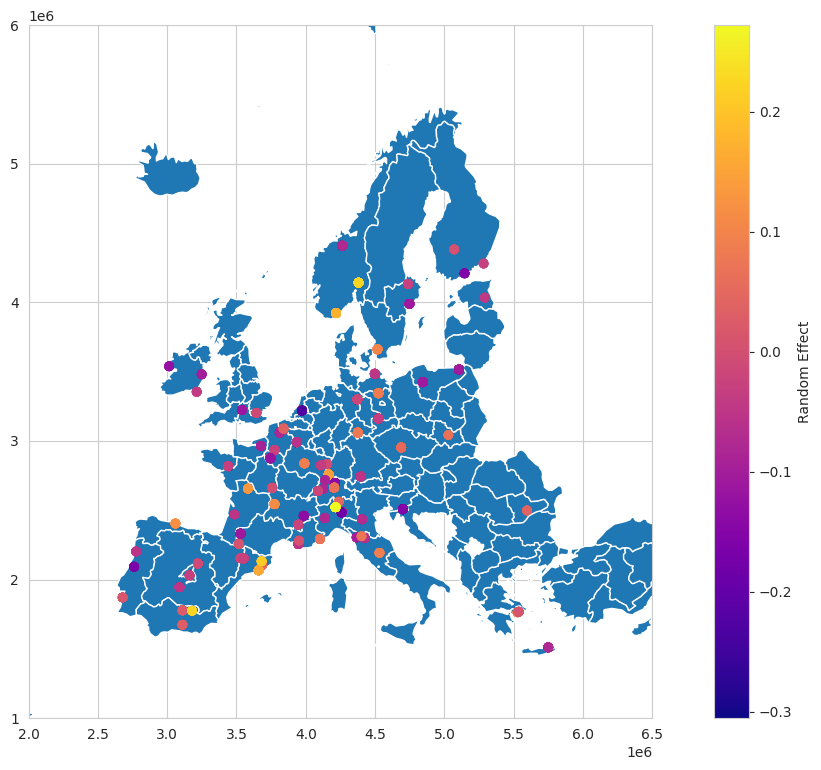

In [ ]:
sns.set_style("whitegrid")
ax = europe.plot(figsize=(16,9), rasterized = True)
res_gpd.to_crs("epsg:3035").plot(ax = ax,
                                    column = res_gpd["random_effect"],marker = "o",
                                    cmap='plasma',legend=True,
                                  rasterized = True, legend_kwds={"label": "Random Effect", "orientation": "vertical", 'shrink': 1}) #'shrink': 0.7
xmin, xmax = 2*10**6 ,6.5*10**6
ymin, ymax = 1*10**6, 6*10**6
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

In [ ]:
# LIST of RANDOM EFFECTS/MEAN PERFORMANCE
res_gpd["re_fixed"] = np.abs(res_gpd["random_effect"]/res_gpd["fixed_effect"])

In [ ]:
res_gpd_online = res_gpd.loc[res_gpd.dataset == "online",:]
res_gpd_riurban = res_gpd.loc[res_gpd.dataset == "riurban",:]
res_gpd_ebas= res_gpd.loc[res_gpd.dataset == "ebas",:]

In [ ]:
ax = europe.plot(figsize=(16,9))
res_gpd_online.to_crs("epsg:3035").plot(ax = ax,
                                    column = res_gpd_online["random_effect"],
                                    cmap='plasma', legend=True)
plt.title("Online")
xmin, xmax = 2*10**6 ,6.5*10**6
ymin, ymax = 1*10**6, 6*10**6
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()

res_gpd_online.sort_values(by = "re_fixed", ascending = False)[["station", "station_id","random_effect","re_fixed"]].drop_duplicates()

In [ ]:
ax = europe.plot(figsize=(16,9))
res_gpd_riurban.to_crs("epsg:3035").plot(ax = ax,
                                    column = res_gpd_riurban["random_effect"],
                                    cmap='plasma', legend=True)
plt.title("Riurban")
xmin, xmax = 2*10**6 ,6.5*10**6
ymin, ymax = 1*10**6, 6*10**6
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()
res_gpd_riurban.sort_values(by = "abs_re", ascending = False)[["station", "station_id","random_effect","abs_re"]].drop_duplicates()

In [ ]:
ax = europe.plot(figsize=(16,9))
res_gpd_ebas.to_crs("epsg:3035").plot(ax = ax,
                                    column = res_gpd_ebas["random_effect"],
                                    cmap='plasma', legend=True)
plt.title("Ebas")
xmin, xmax = 2*10**6 ,6.5*10**6
ymin, ymax = 1*10**6, 6*10**6
plt.xlim([xmin, xmax])
plt.ylim([ymin, ymax])
plt.show()
res_gpd_ebas.sort_values(by="abs_re",ascending = False)[["station","station_id","random_effect","abs_re"]].drop_duplicates()[:10]

In [ ]:
# distribution of random effects
plt.hist(res_gpd.random_effect)